# Ian Mbaya
## Kaggle 4: Diagonal Integration 


## Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim


import seaborn as sns
import matplotlib.pyplot as plt

## Loading  Datasets

In [2]:
modality_1 = pd.read_csv('modality1_train.csv')
modality_2 = pd.read_csv('modality2_train.csv')
test = pd.read_csv('modality1_test.csv')

## Data Exploration & Preparition

#### Separating Features and Samples

In [3]:
## Modality_1
modal1_features = modality_1.iloc[:, [0]]
modality_1 = modality_1.drop(modality_1.columns[0], axis=1)

## Modality_2
modal2_features = modality_2.iloc[:, [0]]
modality_2 = modality_2.drop(modality_2.columns[0], axis=1)

In [4]:
## Test
test_features = test.iloc[:, [0]]
test = test.drop(test.columns[0], axis=1)

### Calculate the minimum and maximum values

In [5]:
#Modality_1
min_value = modality_1.min().min()
max_value = modality_1.max().max()
print("Modality_1 - Min Value is:", min_value, "Max Value is: ", max_value)

#Modality_2
min_value2 = modality_2.min().min()
max_value2 = modality_2.max().max()
print("Modality_2 - Min Value is:", min_value2, "Max Value is: ", max_value2)


Modality_1 - Min Value is: 0.0 Max Value is:  8.25185124169001
Modality_2 - Min Value is: 0.0 Max Value is:  7.54272495074983


The two datasets used in the  model have almost similar data  ranges which is ideal for diagonal integration. However normalizing  these value would  probably help instabilizing the model and making better predictions.  

### Normalizing the Data using log

In [6]:
modality_1 = np.log(modality_1 + 1)
modality_2 = np.log(modality_2 + 1)

#### Convert  Samples to Pytorch Tensor and Transpose

In [7]:
## Convert samples to Arrays
modality_1 = modality_1.to_numpy()
modality_2 = modality_2.to_numpy()


## Convert arrays to Pytorch tesnors
x1 = torch.from_numpy(modality_1).float()
x2 = torch.from_numpy(modality_2).float()


## Transposing
x1 = x1.transpose(0, 1)  
x2 = x2.transpose(0, 1)  


### Visualizing Gene Distribution for Modality1 and Modality 2

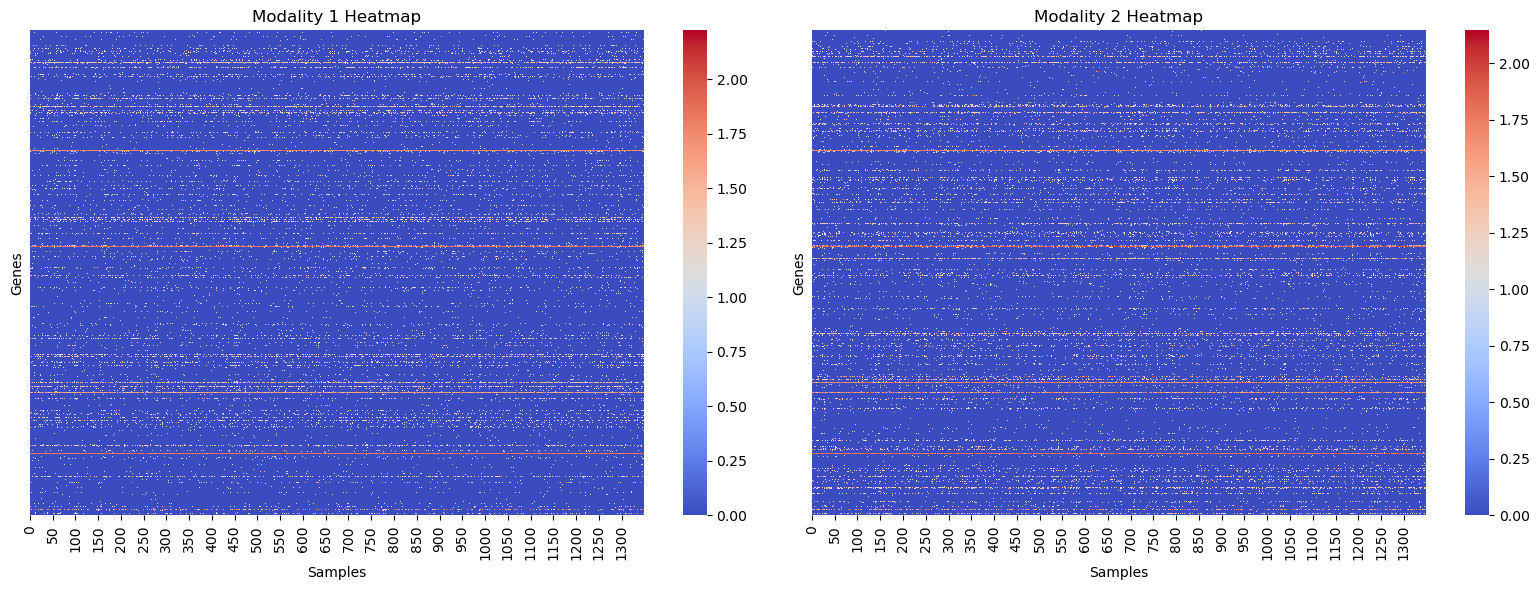

In [66]:
# Set the size of the subplots
plt.figure(figsize=(16, 6))

# Create the first heatmap for modality_1
plt.subplot(1, 2, 1)
sns.heatmap(modality_1, cmap='coolwarm', xticklabels=50, yticklabels=False)
plt.xlabel("Samples")
plt.ylabel("Genes")
plt.title("Modality 1 Heatmap")

# Create the second heatmap for modality_2
plt.subplot(1, 2, 2)
sns.heatmap(modality_2, cmap='coolwarm', xticklabels=50, yticklabels=False)
plt.xlabel("Samples")
plt.ylabel("Genes")
plt.title("Modality 2 Heatmap")

# Adjust spacing between subplots
plt.tight_layout()

# Show the side-by-side heatmaps
plt.show()


## Model Training and Implementation

### Defining Input Features, Encoder, and Decoder Sizes

In [58]:
input_size = 2438
shared_encoder_size = 56
shared_decoder_size = 56
channel_encoder_size = [128, 84]
channel_decoder_size = [128, 84]

### Model Architecture

In [40]:
import torch.nn.functional as F

In [59]:
class TwoChannelAutoencoder(nn.Module):
    def __init__(self, input_size, shared_encoder_size, shared_decoder_size, channel_encoder_size, channel_decoder_size):
        super(TwoChannelAutoencoder, self).__init__()

        # Channel-specific encoder for Channel 1
        self.channel1_encoder = nn.Sequential(
            nn.Linear(input_size, channel_encoder_size[0]),
            nn.ReLU(),
            nn.Linear(channel_encoder_size[0], channel_encoder_size[1]),
            nn.ReLU()
        )

        # Channel-specific encoder for Channel 2
        self.channel2_encoder = nn.Sequential(
            nn.Linear(input_size, channel_encoder_size[0]),
            nn.ReLU(),
            nn.Linear(channel_encoder_size[0], channel_encoder_size[1]),
            nn.ReLU()
        )

        # Shared encoder
        self.shared_encoder = nn.Sequential(
            nn.Linear(channel_encoder_size[1], shared_encoder_size),
            nn.ReLU(),
            nn.Linear(shared_encoder_size, shared_decoder_size),
            nn.ReLU()
        )

        # Shared decoder
        self.shared_decoder = nn.Sequential(
            nn.Linear(shared_decoder_size, shared_encoder_size),
            nn.ReLU(),
            nn.Linear(shared_encoder_size, channel_encoder_size[1]),
            nn.ReLU()
        )

        # Channel-specific decoder for Channel 1
        self.channel1_decoder = nn.Sequential(
            nn.Linear(channel_encoder_size[1], channel_encoder_size[0]),
            nn.ReLU(),
            nn.Linear(channel_encoder_size[0], input_size),
            nn.Sigmoid()
        )

        # Channel-specific decoder for Channel 2
        self.channel2_decoder = nn.Sequential(
            nn.Linear(channel_encoder_size[1], channel_encoder_size[0]),
            nn.ReLU(),
            nn.Linear(channel_encoder_size[0], input_size),
            nn.Sigmoid()
        )

    def forward(self, x1, x2):
        # Encode data from both channels
        encoded_channel1 = self.channel1_encoder(x1)
        encoded_channel2 = self.channel2_encoder(x2)

        # Shared encoding
        shared_encoded = self.shared_encoder(encoded_channel1 + encoded_channel2)

        # Shared decoding
        shared_decoded = self.shared_decoder(shared_encoded)

        # Decode for both channels
        decoded_channel1 = self.channel1_decoder(shared_decoded)
        decoded_channel2 = self.channel2_decoder(shared_decoded)

        return decoded_channel1, decoded_channel2



### Model Training and Implementation

In [60]:
# Create an instance of the TwoChannelAutoencoder
model = TwoChannelAutoencoder(input_size, shared_encoder_size, shared_decoder_size, channel_encoder_size, channel_decoder_size)

# Define the loss function (MSE) and optimizer (Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [61]:
# Training loop with early stopping
num_epochs = 500  
best_loss = float('inf')
early_stopping_threshold = 10  
counter = 0
for epoch in range(num_epochs):
    output1, output2 = model(x1, x2)
    loss1 = criterion(output1, x1)
    loss2 = criterion(output2, x2)
    total_loss = loss1 + loss2

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Early stopping condition
    if total_loss < best_loss:
        best_loss = total_loss
        counter = 0
    else:
        counter += 1
        if counter >= early_stopping_threshold:
            print(f"Stopping early at epoch {epoch}")
            break



## Converting output  from  tensor to Original Shape

In [62]:
# Ensure output tensors are detached and moved to CPU
output1_np = output1.detach().cpu().numpy()
output2_np = output2.detach().cpu().numpy()

# Denormalize the predictions using the exponential function
output1_np = np.exp(output1_np)
output2_np = np.exp(output2_np)

# Convert to Pandas DataFrames
df_output1 = pd.DataFrame(output1_np)
df_output2 = pd.DataFrame(output2_np)

# Transpose the predictions
modality1_pred = df_output1.T
modality2_pred = df_output2.T

## Add index and headers to the data
modality2_pred = pd.concat([modal2_features, modality2_pred], axis=1)

## Hyperparameter Tuning and Cross Validation

In [69]:
from sklearn.metrics import mean_squared_error
# Calculate the Mean Squared Error
mse = mean_squared_error(test, modality1_pred)

print(f"Mean Squared Error (MSE) between Modality1_test and modality_1 predictions is: {mse}")

Mean Squared Error (MSE) between Modality1_test and modality_1 predictions is: 1.1936231649989606


### Innovation

## Melting the dataframe

In [64]:
melted_df = modality2_pred.melt(id_vars=['Unnamed: 0'], var_name='sample', value_name='value')
melted_df['id'] = np.arange(1, len(melted_df) + 1)
melted_df['id'] = 'id_' + melted_df['id'].astype(str)
result = melted_df[['id', 'value']]

In [65]:
#Saving the dataframe
result.to_csv('305.csv', header=True, index=False)

## Conclusion